## COVID-19 of chest X-ray images are detected by VGG16 model (Heatmap)

In [3]:
# import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Activation, Dropout,Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
import time
import pyspark as ps
import seaborn as sns

In [ ]:
# For Covid-19 infected X-ray images (data come from raw_Images/Covid-19)  
if not os.path.exists('../resized_images'):
    os.mkdir('../resized_images')

direcs_Covid = [l for l in os.listdir('../dataset/covid/') if l != '.DS_Store']
print(len(direcs_Covid))
for item in direcs_Covid:
    image = cv2.imread('../dataset/covid/' + item, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)
    if not os.path.exists('../resized_images/Covid19/'):
        os.mkdir('../resized_images/Covid19/')
    cv2.imwrite(str('../resized_images/Covid19/'+ item), img)    

    # file_path1 = './resized_images/Covid19/'
    # imgs_array = [np.array(cv2.imread(file_path1 + item, cv2.IMREAD_GRAYSCALE)) for item in direcs_Covid]
    # print(len(imgs_array))
    # np.save("../X_Covid", imgs_array)

In [7]:
# For Normal (healthy) chest X-ray images
direcs_No = [l for l in os.listdir('../dataset/normal/') if l != '.DS_Store']
for item in direcs_No:    # [:196]
    image = cv2.imread('../dataset/normal/' + item, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)
    if not os.path.exists('../resized_images/Normal/'):
        os.mkdir('../resized_images/Normal/')
    cv2.imwrite(str('../resized_images/Normal/'+ item), img)    

file_path1 = './resized_images/Normal/'
imgs_array = [np.array(cv2.imread(file_path1 + item, cv2.IMREAD_GRAYSCALE)) for item in direcs_No]
np.save("../X_Normal", imgs_array)

In [8]:
# For Pneumonia only 
direcs_Pneumonia = [l for l in os.listdir('../dataset/pneumonia/') if l != '.DS_Store']
for item in direcs_Pneumonia[:196]:
    image = cv2.imread('../dataset/pneumonia/' + item, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)
    if not os.path.exists('../resized_images/Pneumonia/'):
        os.mkdir('../resized_images/Pneumonia/')
    cv2.imwrite(str('../resized_images/Pneumonia/'+ item), img)    

file_path1 = './resized_images/Pneumonia/'
imgs_array = [np.array(cv2.imread(file_path1 + item, cv2.IMREAD_GRAYSCALE)) for item in direcs_Pneumonia]
np.save("../X_Pneumonia", imgs_array)

In [9]:
import imutils
from imutils import paths
dataset_path = '../resized_images'
imagePaths = list(paths.list_images(dataset_path))

data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # print(image.shape)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    # convert the data and labels to NumPy arrays while scaling the pixel
    # intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)
print(len(labels))

696


In [10]:
# We only consider Covid19 and Normal here ! (remove Pneumonia from resized_images) )
print(data.shape)

(696, 224, 224, 3)


In [11]:
# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

## VGG16 model

In [12]:
# Load VGG16 model
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.6)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

import warnings
warnings.filterwarnings("ignore")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# Initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 30
BS = 8

In [14]:
# Training 
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# or loss = 'binary_crossentropy'

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
69/69 [==============================] - 11s 155ms/step - loss: 0.6088 - accuracy: 0.7135 - val_loss: 0.4410 - val_accuracy: 0.7929
Epoch 2/30
69/69 [==============================] - 8s 115ms/step - loss: 0.4889 - accuracy: 0.7938 - val_loss: 0.3782 - val_accuracy: 0.8571
Epoch 3/30
69/69 [==============================] - 8s 117ms/step - loss: 0.4160 - accuracy: 0.8139 - val_loss: 0.3562 - val_accuracy: 0.8143
Epoch 4/30
69/69 [==============================] - 8s 117ms/step - loss: 0.3834 - accuracy: 0.8339 - val_loss: 0.2916 - val_accuracy: 0.9071
Epoch 5/30
69/69 [==============================] - 8s 116ms/step - loss: 0.3592 - accuracy: 0.8412 - val_loss: 0.2803 - val_accuracy: 0.9000
Epoch 6/30
69/69 [==============================] - 8s 115ms/step - loss: 0.3404 - accuracy: 0.8449 - val_loss: 0.2609 - val_accuracy: 0.9143
Epoch 7/30
69/69 [===

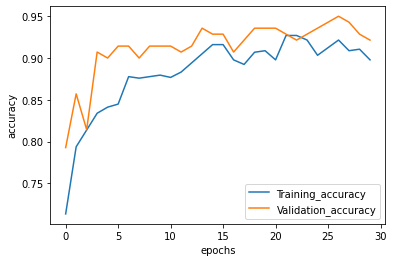

In [15]:
# Plot the accuracy.
accs = H.history['accuracy']
val_accs = H.history['val_accuracy']
plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

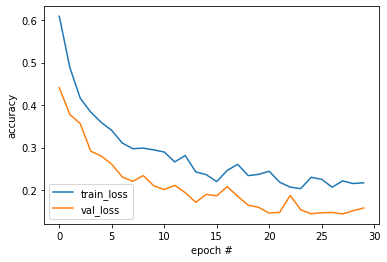

In [16]:
# Plot the training loss.
N = EPOCHS
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.xlabel("epoch #")
plt.ylabel("accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [17]:
# Confusion matrix on test data
y_test_hat = model.predict(testX, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(testY, axis=1)

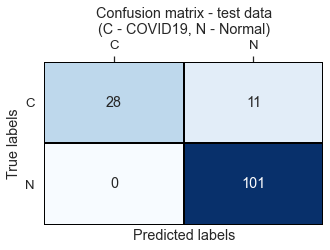

Classification report on test data
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        39
           1       0.90      1.00      0.95       101

    accuracy                           0.92       140
   macro avg       0.95      0.86      0.89       140
weighted avg       0.93      0.92      0.92       140



In [18]:
# Calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# Plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['C', 'N'], yticklabels=['C', 'N'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(C - COVID19, N - Normal)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)

In [20]:
# import cv2
# import matplotlib.pyplot as plt
# %matplotlib inline
# from PIL import Image

# img = cv2.imread('../dataset/heatmap/test1.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (224, 224))
# print(img.shape)
# plt.imshow(img)
# plt.show()

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

In [24]:
# img_path = '../dataset/covid/16865_1_1.jpg'
img_path = '../dataset/covid/40779_2020_233_Fig2_HTML-a.png'

size = (224, 224)
img = keras.preprocessing.image.load_img(img_path, target_size=size)
array = keras.preprocessing.image.img_to_array(img)
# We add a dimension to transform our array into a "batch"
# of size (1, 299, 299, 3)
img_array = np.expand_dims(array, axis=0)
img_array.shape

(1, 224, 224, 3)

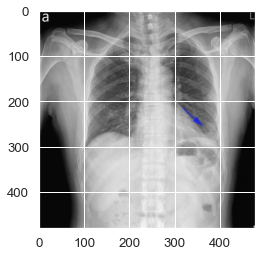

In [25]:
img = cv2.imread(img_path)
plt.imshow(img)

### Heatmap by Grad-Cam method

In [26]:
# Show the COV19-infected areas with Heatmap.
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # Firstly create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # The gradient 
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # Normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [27]:
last_conv_layer_name = 'block5_conv3'
classifier_layer_names= ['flatten', 'dropout']
make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.6716571e-03],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.6934263e-03,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.0676627e-02,
        6.6537480e-03, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 5.3827246e-03],
       [0.0000000e+00, 0.000

(14, 14, 3)


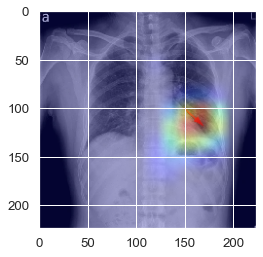

In [31]:
# img = keras.preprocessing.image.load_img(img_path)
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
print(jet_heatmap.shape)

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((array.shape[1], array.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.5 + array
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
plt.imshow(superimposed_img)
# Save the superimposed image
# save_path = "elephant_cam.jpg"
# superimposed_img.save(save_path)

# Display Grad CAM
# display(Image(save_path))

### Conclusion: 
The highlighted heatmaps of lung regions potentially contain most features of COVID-19 infection 
which are extracted with Grad-Cam method, and the red arrow shows that most of the infected area 
was annotated by our board certified radiologist (on the right).